# Convolutional Neural Network

In [22]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
100%|█████████▉| 170426368/170498071 [00:32<00:00, 4577445.31it/s]Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Visualize the data

In [24]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor imageimport matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

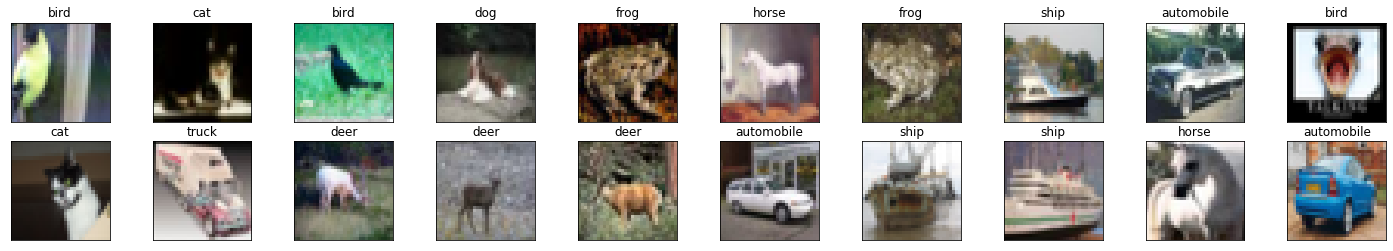

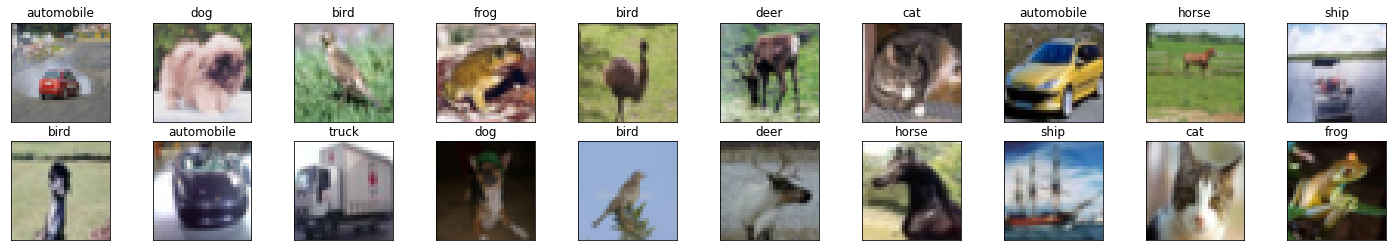

In [25]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

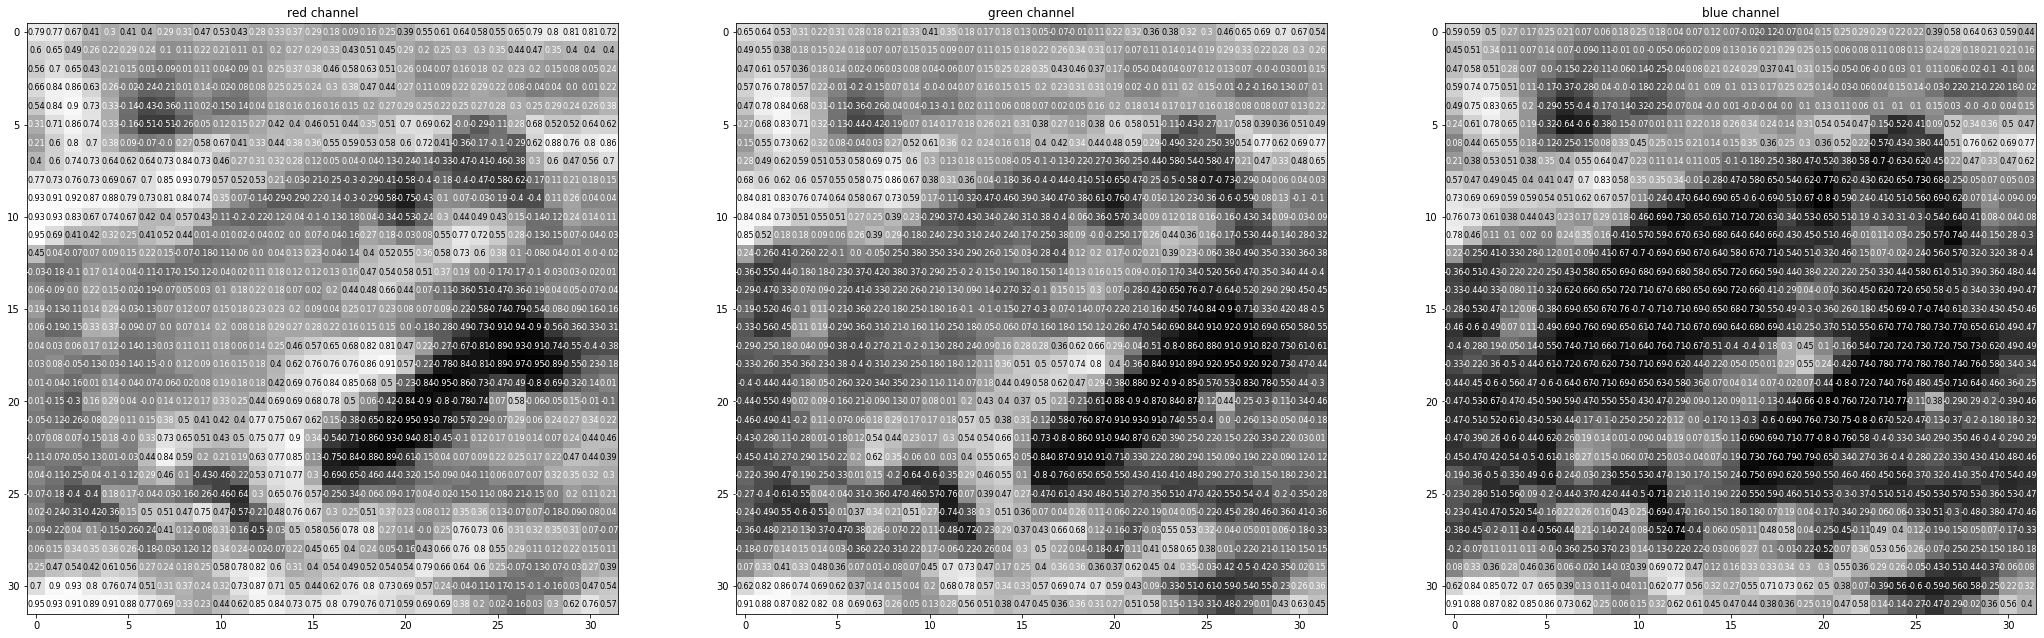

In [26]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

[Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d)

[MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d)

In [34]:
import torch
from torch import nn, optim

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(-1, 1024)

class Network(nn.Module):
    def __init__(self, drop_p=0.2):
        super(Network, self).__init__()
        # three conv layers, flatten image, two linear layers
        self.model = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(16, 32, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(32, 64, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    Flatten(),
                                    nn.Dropout(p=drop_p),
                                    nn.Linear(1024, 500),
                                    nn.ReLU(),
                                    nn.Dropout(p=drop_p),
                                    nn.Linear(500, 10),
                                    nn.LogSoftmax(dim=1))
        # Negative Log Liklihood pairs with LogSoftmax
        self.criterion = nn.NLLLoss()
        # Define the first-order gradient-based optimization of Stochastic Gradient Descent
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.003)

    def forward(self, x):
        """
        Forward pass sends x through the sequential model, which has the
        weights and bias built into them
        Input:
        * x: the collection of elements in a record
        """
        return self.model(x)

    def fit(self, trainloader, valloader):
        """
        This function is responsible for training the model
        Input:
        * trainloader: The MINST training data loader
        * valloader: The MINST validation data loader
        """
        # Initialize tracker for minimum validation loss
        valid_loss_min = np.Inf
        # Debug - number of images trained
        trained_so_far = 0
        # Debug - time stamp when function was executed
        start = time.time()
        # Debug - total loss for training and validation data
        train_losses, val_losses = [], []
        # count controlled loop based on model's epoch
        for e in range(self.epochs):
        # Debug - training loss for each inner loop
        running_loss = 0
        # count controlled loop based on n_records of training data
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            # Clear out the parameters of the optimizer
            self.optimizer.zero_grad()
            # Forward pass
            output = self.forward(images)
            # Calculate the loss with the output and the labels
            loss = self.criterion(output, labels)
            # Backward pass
            loss.backward()
            # Gradient Step
            self.optimizer.step()
            # Debug - update number of images trained
            trained_so_far += len(labels)
            # Debug - update the training loss
            running_loss += loss.item() * images.size(0)
        else: # once inner loop completes, print debug data
            # Debug - validation loss
            val_loss = 0
            # Turn off gradient for CPU/GPU speed boost
            with torch.no_grad():
            # Set model to evaluation mode
            self.model.eval()
            # count controlled loop based on n_records in validation data
            for images, labels in valloader:
                # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)
                # Forward pass
                log_ps = self.forward(images)
                # Calculate the loss with the output and the labels
                loss = self.criterion(log_ps, labels)
                # Calculate the accuracy of the loss
                ps = torch.exp(log_ps)
                # Get the largest probability values per record
                _, top_class = ps.topk(1, dim=1)
                # Compare to the list of Ground Truth
                equals = top_class == labels.view(*top_class.shape)
                # Calculate the validation loss
                val_loss += loss * images.size(0)
            # Set the model back to train mode
            self.model.train()
            # Debug - append the training loss for each epoch to the list
            running_loss = running_loss/len(trainloader.sampler)
            # Debug - append the validation loss for each epoch to the list
            val_loss = val_loss/len(valloader.sampler)
            # Debug - calculate the time it took to complete one epoch
            elapsed_time = float(time.time() - start)
            # Debug - calculate the number of images trainer per second in one epoch
            images_per_second = trained_so_far / elapsed_time if elapsed_time > 0 else 0
            # Debug - display debug information
            print("Epoch: {}/{}.. ".format(e+1, self.epochs),
                "Training loss: {:.3f}..".format( running_loss ),
                "Validation Loss: {:.3f}..".format( val_loss ),
                "Speed(images/sec): {:.2f}..".format( images_per_second ))
            # save model if validation loss has decreased
            if val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_loss))
            self.save_checkpoint()
            valid_loss_min = val_loss
        # Debug - display the time it took for the total training to complete
        print("Total elapse time: {:.2f} seconds".format(float(time.time() - start)))
        # Load the best model back into the current state
        self.load_checkpoint()

  def test(self, testloader):
    """
    This function is responsible for testing the trained model on data that it has not
    seen before. 
    Input:
    * testloader: MNIST training data loader
    """
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)

    # Debug - testing loss for each inner loop
    running_loss = 0
    # Debug - number of images trained
    trained_so_far = 0
    # Debug - time stamp when function was executed
    start = time.time()
    # Turn off gradient for CPU/GPU speed boost
    with torch.no_grad():
      # Set model to evaluation mode
      self.model.eval()
      # count controlled loop based on n_records of testing data
      for images, labels in testloader:
        # Debug - update number of images trained
        trained_so_far += len(labels)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        # Clear out the parameters of the optimizer
        self.optimizer.zero_grad()
        # Forward pass
        output = self.forward(images)
        # Calculate the loss with the output and the labels
        loss = self.criterion(output, labels)
        # Calculate the accuracy of the loss
        ps = torch.exp(output)
        # Get the largest probability values per record
        _, top_class = ps.topk(1, dim=1)
        # Compare to the list of Ground Truth
        equals = top_class == labels.view(*top_class.shape)
        # Debug - update the testing loss
        running_loss += loss.item() * images.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(labels)):
          target = labels.data[i]
          class_correct[target] += correct[i].item()
          class_total[target] += 1
    # Debug - calculate avg test loss
    running_loss = running_loss/len(testloader.sampler)
    print("Test Loss: {:.6f}\n".format(running_loss))
    for i in range(10):
      if class_total[i] > 0:
        print("Test Accuracy of {}: {:.2f}% ({:}/{:})".format(i, 
                    100 * class_correct[i] / class_total[i],
                    torch.sum(class_correct[i]).int(), 
                    torch.sum(class_total[i]).int() ))
      else:
          print("Test Accuracy of {:.2f}: N/A (no training examples)".format(classes[i]))
    print("\nTest Accuracy (Overall): {:.2f}% ({}/{})".format(100. * torch.sum(class_correct) / torch.sum(class_total),
                        torch.sum(class_correct).int(), 
                        torch.sum(class_total).int() ))
    # Set the model back to train mode
    self.model.train()

  def save_checkpoint(self, filepath='checkpoint.tar'):
    """
    This function is responsible for saving a copy of the model's data
    Input:
    * filepath: (Optional) PATH name using the convention *.tar
    """
    # Extract the data from the model: in_features and out_features for each linear layer,
    # the model's state dictionary, and the optimizer's state dictionary
    checkpoint = {'input_size': self.input_size,
                'output_size': self.output_size,
                'hidden_layers': [each.out_features for each in self.model[0:-2:3]],
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict()}
    # Save the model's data to a tar file
    torch.save(checkpoint, filepath)

  def load_checkpoint(self, filepath='checkpoint.tar'):
    """
    This function is responsible for loading a copy of a model's data
    that was previosuly stored to disk
    Input:
    * filepath: (Optional) PATH name using the convention *.tar
    """
    # Load the data
    checkpoint = torch.load(filepath)
    # Create an ordered dictionary to hold the modified model's state dictionary
    new_state_dict = collections.OrderedDict()
    # Append 'model.' to each of the model_state_dict elements
    for k, v in checkpoint['model_state_dict'].items():
      # prepend 'model.' to each of the keys
      name = ''.join(('model.', k))
      # copy the key-value pair into the new container
      new_state_dict[name] = v
    # create a new network based on the old network's parameters
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    # load the model's state dictionary of the old into the new
    model.load_state_dict(new_state_dict)
    # load the optimizer's state dictionary of the old into the new
    model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # turn training off
    model.eval()
    return model

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 129)

In [31]:
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Network(weight,1,0,[4])

TypeError: __init__() takes from 1 to 2 positional arguments but 5 were given